# Reconstruction of the diffusion signal with the Tensor model

The diffusion tensor model is a model that describes the diffusion within a
voxel. First proposed by Basser and colleagues [Basser1994]_, it has been very
influential in demonstrating the utility of diffusion MRI in characterizing the
micro-structure of white matter tissue and of the biophysical properties of
tissue, inferred from local diffusion properties and it is still very commonly
used.

The diffusion tensor models the diffusion signal as:

$\frac{S(\mathbf{g}, b)}{S_0} = e^{-b\mathbf{g}^T \mathbf{D} \mathbf{g}}$

Where $\mathbf{g}$ is a unit vector in 3 space indicating the direction of
measurement and b are the parameters of measurement, such as the strength and
duration of diffusion-weighting gradient. $S(\mathbf{g}, b)$ is the
diffusion-weighted signal measured and $S_0$ is the signal conducted in a
measurement with no diffusion weighting. $\mathbf{D}$ is a positive-definite quadratic
form, which contains six free parameters to be fit. These six parameters are:

   $\mathbf{D} = \begin{pmatrix} D_{xx} & D_{xy} & D_{xz} \\
                       D_{yx} & D_{yy} & D_{yz} \\
                       D_{zx} & D_{zy} & D_{zz} \\ \end{pmatrix}$

This matrix is a variance/covariance matrix of the diffusivity along the three
spatial dimensions. Note that we can assume that diffusivity has antipodal
symmetry, so elements across the diagonal are equal. For example:
$D_{xy} = D_{yx}$. This is why there are only 6 free parameters to estimate
here.

In the following example we show how to reconstruct your diffusion datasets
using a single tensor model.

First import the necessary modules:

``numpy`` is for numerical computation

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

We will also import elements needed in order to display images in the notebook:

In [4]:
from IPython import display

``nibabel`` is for loading imaging datasets

In [5]:
import nibabel as nib

``dipy.reconst`` is for the reconstruction algorithms which we use to create
voxel models from the raw data.

In [6]:
import dipy.reconst.dti as dti

``dipy.data`` is used for small datasets that we use in tests and examples.

In [7]:
from dipy.data import fetch_stanford_hardi

Fetch will download the raw dMRI dataset of a single subject. The size of the
dataset is 87 MBytes.  You only need to fetch once.

In [8]:
fetch_stanford_hardi()

Dataset is already in place. If you want to fetch it again, please first remove the folder /Users/arokem/.dipy/stanford_hardi 


Next, we read the saved dataset

In [9]:
from dipy.data import read_stanford_hardi
img, gtab = read_stanford_hardi()

img contains a nibabel Nifti1Image object (with the data) and gtab contains a
GradientTable object (information about the gradients e.g. b-values and
b-vectors).

In [10]:
data = img.get_data()
print('data.shape (%d, %d, %d, %d)' % data.shape)

data.shape (81, 106, 76, 160)


First of all, we mask and crop the data. This is a quick way to avoid
calculating Tensors on the background of the image. This is done using dipy's
mask module.

In [11]:
from dipy.segment.mask import median_otsu
maskdata, mask = median_otsu(data, 3, 1, True,
                             vol_idx=range(10, 50), dilate=2)
print('maskdata.shape (%d, %d, %d, %d)' % maskdata.shape)

maskdata.shape (71, 87, 62, 160)


Now that we have prepared the datasets we can go forward with the voxel
reconstruction. First, we instantiate the Tensor model in the following way.

In [12]:
tenmodel = dti.TensorModel(gtab)

Fitting the data is very simple. We just need to call the fit method of the
TensorModel in the following way:

In [13]:
tenfit = tenmodel.fit(maskdata)

The fit method creates a TensorFit object which contains the fitting parameters
and other attributes of the model. For example we can generate fractional
anisotropy (FA) from the eigen-values of the tensor. FA is used to characterize
the degree to which the distribution of diffusion in a voxel is
directional. That is, whether there is relatively unrestricted diffusion in one
particular direction.

Mathematically, FA is defined as the normalized variance of the eigen-values of
the tensor:


$FA = \sqrt{\frac{1}{2}\frac{(\lambda_1-\lambda_2)^2+(\lambda_1-
            \lambda_3)^2+(\lambda_2-\lambda_3)^2}{\lambda_1^2+
            \lambda_2^2+\lambda_3^2}}$

Note that FA should be interperted carefully. It may be an indication of the
density of packing of fibers in a voxel, and the amount of myelin wrapping these
axons, but it is not always a measure of "tissue integrity". For example, FA
may decrease in locations in which there is fanning of white matter fibers, or
where more than one population of white matter fibers crosses.

In [14]:
from dipy.reconst.dti import fractional_anisotropy, color_fa, lower_triangular
FA = fractional_anisotropy(tenfit.evals)

In the background of the image the fitting will not be accurate there is no
signal and possibly we will find FA values with nans (not a number). We can
easily remove these in the following way.

In [15]:
FA[np.isnan(FA)] = 0

Saving the FA images is very easy using nibabel. We need the FA volume and the
affine matrix which transform the image's coordinates to the world coordinates.
Here, we choose to save the FA in float32.

In [16]:
fa_img = nib.Nifti1Image(FA.astype(np.float32), img.get_affine())
nib.save(fa_img, 'tensor_fa.nii.gz')

You can now see the result with any nifti viewer or check it slice by slice
using matplotlib_'s imshow. In the same way you can save the eigen values, the
eigen vectors or any other properties of the Tensor.

In [17]:
evecs_img = nib.Nifti1Image(tenfit.evecs.astype(np.float32), img.get_affine())
nib.save(evecs_img, 'tensor_evecs.nii.gz')

Other tensor statistics can be calculated from the `tenfit` object. For example,
a commonly calculated statistic is the mean diffusivity (MD). This is simply the
mean of the  eigenvalues of the tensor. Since FA is a normalized
measure of variance and MD is the mean, they are often used as complimentary
measures. In `dipy`, there are two equivalent ways to calculate the mean
diffusivity. One is by calling the `mean_diffusivity` module function on the
eigen-values of the TensorFit class instance:

In [18]:
MD1 = dti.mean_diffusivity(tenfit.evals)
nib.save(nib.Nifti1Image(MD1.astype(np.float32), img.get_affine()), 'tensors_md.nii.gz')

The other is to call the TensorFit class method:

In [19]:
MD2 = tenfit.md

Obviously, the quantities are identical.

We can also compute the colored FA or RGB-map [Pajevic1999]_. First, we make sure
that the FA is scaled between 0 and 1, we compute the RGB map and save it.

In [20]:
FA = np.clip(FA, 0, 1)
RGB = color_fa(FA, tenfit.evecs)
nib.save(nib.Nifti1Image(np.array(255 * RGB, 'uint8'), img.get_affine()), 'tensor_rgb.nii.gz')

Let's try to visualize the tensor ellipsoids of a small rectangular
area in an axial slice of the splenium of the corpus callosum (CC).

In [21]:
from dipy.data import get_sphere
sphere = get_sphere('symmetric724')

from dipy.viz import fvtk
ren = fvtk.ren()

evals = tenfit.evals[13:43, 44:74, 28:29]
evecs = tenfit.evecs[13:43, 44:74, 28:29]

We can color the ellipsoids using the ``color_fa`` values that we calculated
above. In this example we additionally normalize the values to increase the contrast.

In [22]:
ren.SetBackground(1, 1, 1)

In [23]:
cfa = RGB[13:43, 44:74, 28:29]
cfa /= cfa.max()

fvtk.clear(ren)
fvtk.add(ren, fvtk.tensor(evals, evecs, cfa, sphere, scale=2.2))

print('Saving illustration as tensor_ellipsoids.png')
fvtk.record(ren, n_frames=1, out_path='tensor_ellipsoids.png', size=(600, 600))

Saving illustration as tensor_ellipsoids.png


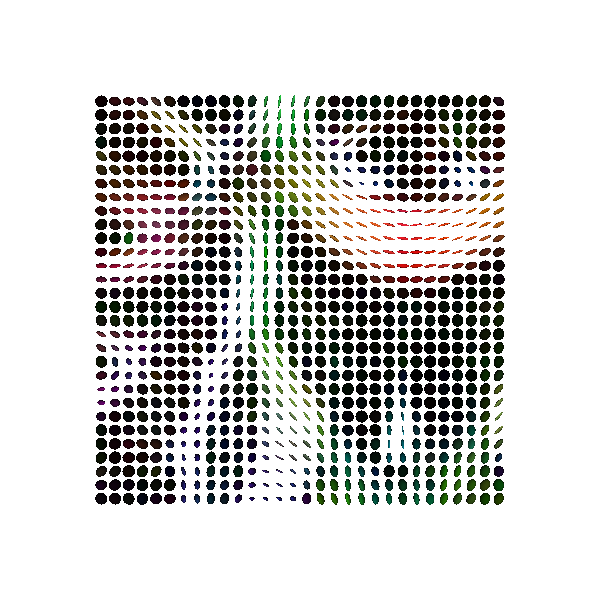

In [24]:
display.display(display.Image('tensor_ellipsoids.png'))

In [25]:
fvtk.camera

<function dipy.viz.fvtk.camera>

In [26]:
tensor_odfs = tenmodel.fit(data[20:50, 55:85, 38:39]).odf(sphere)
fvtk.clear(ren)
fvtk.add(ren, fvtk.sphere_funcs(tensor_odfs, sphere, colormap=None))
fvtk.record(ren, n_frames=1, out_path='tensor_odfs.png', size=(600, 600))

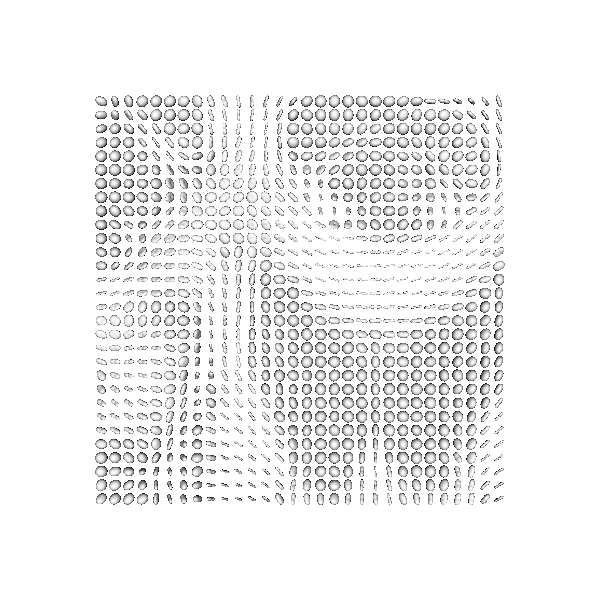

In [27]:
display.display(display.Image('tensor_odfs.png'))

Note that while the tensor model is an accurate and reliable model of the
diffusion signal in the white matter, it has the drawback that it only has one
principal diffusion direction. Therefore, in locations in the brain that
contain multiple fiber populations crossing each other, the tensor model may
indicate that the principal diffusion direction is intermediate to these
directions. Therefore, using the principal diffusion direction for tracking in
these locations may be misleading and may lead to errors in defining the
tracks. Fortunately, other reconstruction methods can be used to represent the
diffusion and fiber orientations in those locations. These are presented in
other examples.


### References

[Basser1994] Basser PJ, Mattielo J, LeBihan (1994). MR diffusion tensor spectroscopy and imaging.

[Pajevic1999] Pajevic S, Pierpaoli (1999). Color schemes to represent the orientation of anisotropic tissues from diffusion tensor data: application to white matter fiber tract mapping in the human brain.


In [28]:
import seaborn as sns

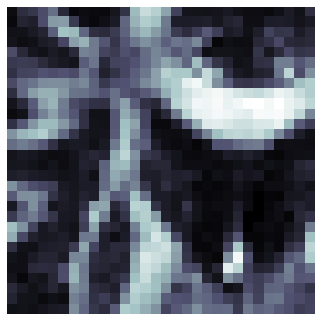

In [29]:
fig, ax = plt.subplots(1)
ax.matshow(np.flipud(FA[13:43, 44:74, 28].T), cmap=matplotlib.cm.bone)
ax.set_xticks([])
ax.set_yticks([])
fig.savefig("d2t-bkgrnd.png", transparent=True)

In [ ]:
tensor_odfs = tenmodel.fit(data[40, 70, 33]).odf(sphere)
fvtk.clear(ren)
fvtk.add(ren, fvtk.sphere_funcs(tensor_odfs, sphere, colormap='hot'))
fvtk.record(ren, n_frames=360, out_path='./tensor_signal/', size=(600, 600), az_ang=1)

In [ ]:
import moviepy.editor as mp
imseq = mp.ImageSequenceClip('./tensor_ellipses/', fps=18)
imseq.write_videofile('./tensor-odf-movie.mp4')

In [46]:
tensor_odfs = tenmodel.fit(data[40, 70, 33]).odf(sphere)
fvtk.clear(ren)

fvtk.add(ren, fvtk.sphere_funcs(tensor_odfs, sphere, colormap='hot'))
fvtk.record(ren, n_frames=360, out_path='./tensor_odfs/', size=(600, 600), az_ang=1)

In [47]:
import moviepy.editor as mp
imseq = mp.ImageSequenceClip('./tensor_odfs/', fps=18)
imseq.write_videofile('./tensor-odf-movie.mp4')

[MoviePy] >>>> Building video ./tensor-odf-movie.mp4
[MoviePy] Writing video ./tensor-odf-movie.mp4
[MoviePy] Done.
[MoviePy] >>>> Video ready: ./tensor-odf-movie.mp4 



In [67]:
tensor_evecs = tenmodel.fit(data[40, 70, 33]).evecs
tensor_evals = tenmodel.fit(data[40, 70, 33]).evals

fvtk.clear(ren)
fvtk.add(ren, fvtk.tensor(tensor_evals, tensor_evecs, scalar_colors=np.array([0, 0, 1])))
fvtk.record(ren, n_frames=360, out_path='./tensor_ellipses/', size=(600, 600), az_ang=1)

In [68]:
import moviepy.editor as mp
imseq = mp.ImageSequenceClip('./tensor_ellipses/', fps=18)
imseq.write_videofile('./tensor-ellipse-movie.mp4')

[MoviePy] >>>> Building video ./tensor-ellipse-movie.mp4
[MoviePy] Writing video ./tensor-ellipse-movie.mp4
[MoviePy] Done.
[MoviePy] >>>> Video ready: ./tensor-ellipse-movie.mp4 



In [81]:
points = gtab.bvecs[~gtab.b0s_mask] * (np.log(data[40, 70, 33, ~gtab.b0s_mask]/np.mean(data[40, 70, 33, gtab.b0s_mask]))/-2)[:, None]

In [82]:
points.shape

(150, 3)

In [85]:
fvtk.clear(ren)
fvtk.add(ren, fvtk.point(points, fvtk.colors.blue))
fvtk.record(ren, n_frames=360, out_path='./tensor_signal//', size=(600, 600), az_ang=1)

In [86]:
import moviepy.editor as mp
imseq = mp.ImageSequenceClip('./tensor_signal/', fps=18)
imseq.write_videofile('./tensor-signal-movie.mp4')

[MoviePy] >>>> Building video ./tensor-signal-movie.mp4
[MoviePy] Writing video ./tensor-signal-movie.mp4
[MoviePy] Done.
[MoviePy] >>>> Video ready: ./tensor-signal-movie.mp4 



In [32]:
#fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')
#for ii in range(sig1.shape[0]):
#    x,y,z = gtab.bvecs[ii]
#    this_sig = np.array([sig1[ii]])
#    ax.plot3D(this_sig * x , this_sig * y, this_sig * z, 'b.')
#    ax.axis('off')